# Import libraries

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import random
import math
import matplotlib.ticker as tick

%matplotlib inline

# Import data

In [2]:
# upload datasets 
data = pd.read_csv('transactions.csv', sep=';')
codes = pd.read_csv('codes.csv', sep=';')
types = pd.read_csv('types.csv',sep=';')
train = pd.read_csv('train_set.csv', sep=';')
test = pd.read_csv('test_set.csv', sep=';')

In [3]:
# only clients from train
data = data.merge(train)
data.head()

,client_id,datetime,code,type,sum,target
0,96372458,421 06:33:15,6011,2010,-561478.94,0
1,96372458,270 06:16:18,6011,7010,224591.58,0
2,96372458,97 10:48:35,4829,2370,-11229.58,0
3,96372458,445 07:33:38,4829,2330,-417695.42,0
4,96372458,4 09:33:46,4814,1030,-2245.92,0


# 1. Data Observe

## 1.1 Data description

In [4]:
# representing description of sum column(quartiles, median, mean, std, max, min)
data['sum'].describe()

count    9.182600e+04
mean    -1.666997e+04
std      6.232297e+05
min     -4.150030e+07
25%     -2.156079e+04
50%     -5.239160e+03
75%     -1.122960e+03
max      6.737747e+07
Name: sum, dtype: float64

In [5]:
# get rid of '-' sign
data_abs = data.copy()
data_abs['abs_sum'] = data['sum'].apply(lambda x: abs(x))

In [6]:
# describe absolute values for sum
data_abs['abs_sum'].describe()

count    9.182600e+04
mean     8.147385e+04
std      6.181061e+05
min      2.200000e-01
25%      3.520925e+03
50%      1.082531e+04
75%      3.630467e+04
max      6.737747e+07
Name: abs_sum, dtype: float64

## 1.3 Searching for outliers

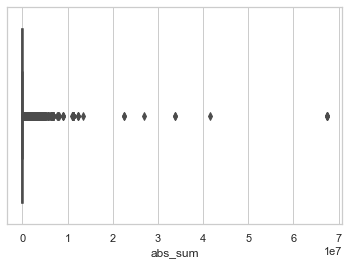

In [7]:
# boxplot which represents ouliers in absolute sum column
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data_abs["abs_sum"])

Text(0.5, 1.0, 'Absolute sum boxplot')

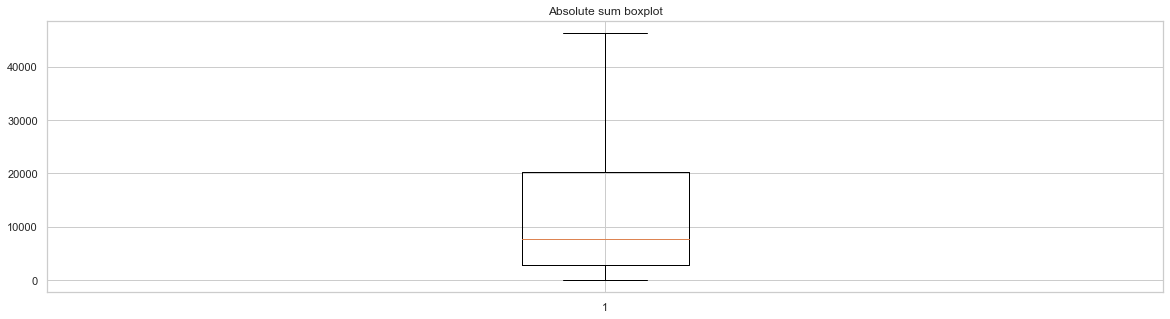

In [8]:

# observing the box plot of absolute sum values without outliers based on IQR
Q1 = data_abs['abs_sum'].quantile(0.25)
Q3 = data_abs['abs_sum'].quantile(0.75)
IQR = Q3 - Q1

No_outliers = []
for i in data_abs['abs_sum']:
    if i > (Q1 - 1.5 * IQR) and i < (Q3 + 1.5 * IQR):
        No_outliers.append(i)

No_outliers = pd.DataFrame(No_outliers)
No_outliers = No_outliers.rename(columns={0:'sum'})

plt.figure(figsize=(20, 5))

plt.subplot(1, 1, 1)
plt.boxplot(No_outliers['sum'], showfliers=False)
plt.title('Absolute sum boxplot')

## 1.5 Conclusion

**Clearing such a large number of outliers will lead to the loss of the essence of the entire clustering, so the decision was made to keep everything.**

# 2. Data Cleaning

## 2.1 Missing values

In [9]:
# copy dataset to identify missing values
data_missing_values = data.copy()
data_missing_value = data_missing_values.dropna(subset=['client_id'])

In [10]:
# information about columns in dataset 
data_missing_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91826 entries, 0 to 91825
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  91826 non-null  int64  
 1   datetime   91826 non-null  object 
 2   code       91826 non-null  int64  
 3   type       91826 non-null  int64  
 4   sum        91826 non-null  float64
 5   target     91826 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 4.9+ MB


Text(0.5, 1.0, 'Ratio of missing values per columns')

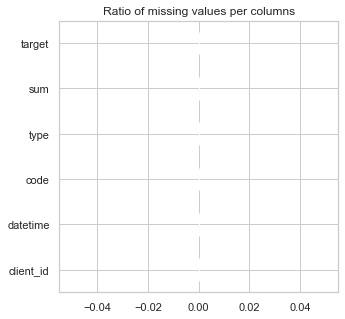

In [11]:
# at this plot we can see that 
plt.figure(figsize=(5, 5))
data_missing_values.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

As the result, we can observe that the dataset has no missing values in it. Hence, it means that data was correctly scrapped.

## 2.2 Drop duplicates

In [12]:
# create new dataframe by making a copy from initial dataset
data_duplicates = data.copy()

In [13]:
# representing number of exactly the same entries in dataframe
print('Dupplicate entries: {}'.format(data_duplicates.duplicated().sum()))
data_duplicates.drop_duplicates(inplace = True)

Dupplicate entries: 19


## 2.3 Data with invalid code/type values

### 2.3.1 Removing rows if their type/code is not found in codes/types tables

In [14]:
# converting codes and types to lists 
type_list = types['type'].to_list()
code_list = codes['code'].to_list()
data = data[data['type'].isin(type_list) & data['code'].isin(code_list)]

# delete unnecessary lists
del type_list, code_list

### 2.3.2 Removing rows if the description of their code/type values are invalid in codes/types tables

In [15]:
# removing н/д
nan_types = types['type'][types['type_description'] == 'н/д'].to_list()
data = data[~data['type'].isin(nan_types)]

### 2.3.3 Due to types table contains duplicates in type description we shoud remove these duplicates and replace invalid types in general dataframe 

In [16]:
# deleting duplicates of types from general data

dict_for_types = {}
for row in types.values:
    list_of_types = []
    for row2 in types.values:
        if row[1] == row2[1]:
            list_of_types.append(row2[0])
    while len(list_of_types) > 1:
        dict_for_types[list_of_types[-1]] = list_of_types[0]
        list_of_types = list_of_types[:-1]
data['type'] = data['type'].apply(lambda x: dict_for_types.get(x) if dict_for_types.get(x) != None else x)

### 2.3.4 Removing duplicates and ivalid data from types table

In [17]:
# deleting all 'garbage' values from table 'types'
types = types.drop_duplicates('type_description', keep='first')
types = types[~types['type_description'].str.contains('н/д')]
types = types[~types['type_description'].str.contains('н/д(нет данных)')]
types = types[~types['type_description'].str.contains('XXX')]

# 3. Exploratory Data Analysis

## 3.1 Analysis of transactions distributed according to hours

In [18]:
# eda 
hours_distribution = data.copy()
# copy dataset to work with time
hours_distribution = data.copy()
# split days and time from column datetime
hours_distribution[['day', 'time']] = hours_distribution['datetime'].str.split(' ', 1, expand=True)
# get only hours from time column
hours_distribution['time'] = pd.to_datetime(hours_distribution['time'], format='%H:%M:%S')
hours_distribution['hh']= hours_distribution['time'].dt.hour

time_hh = []
for i in hours_distribution['hh']:
    if i >=0 and i < 13:
        time_hh.append("Morning")
    elif i >= 13 and i<=17:
        time_hh.append("Afternoon")
    elif i > 17 and i <= 19:
        time_hh.append("Evening")
    elif i > 19:
        time_hh.append("Night")

# inserting times in transactions time of day column
hours_distribution["TransactionTimeOfDay"] = time_hh
hours_distribution['abs_sum'] = hours_distribution['sum'].apply(lambda x: abs(x))

In [19]:
# take a description of abs_sum column
hours_distribution['abs_sum'].describe()

count    9.172500e+04
mean     8.147748e+04
std      6.184290e+05
min      2.200000e-01
25%      3.520700e+03
50%      1.081408e+04
75%      3.623852e+04
max      6.737747e+07
Name: abs_sum, dtype: float64

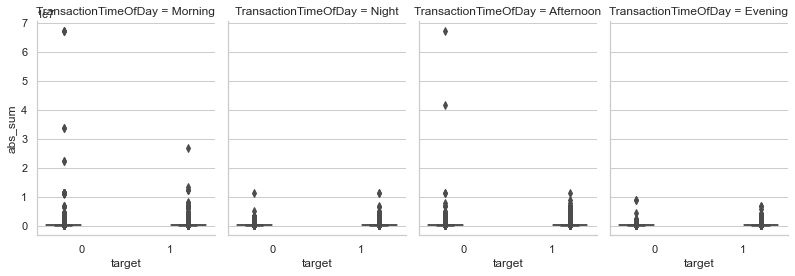

In [20]:
# graph represents abs_sum based on time distribution between targets
graph1 = sns.catplot(x="target", y="abs_sum",
                hue="target", col="TransactionTimeOfDay",
                data=hours_distribution, kind="box",
                height=4, aspect=.7);


In [21]:
# removing outlires from abs sum in [-2] represents 0.75, [-4] represents 0.25
iqr = hours_distribution['abs_sum'].describe()[-2] - hours_distribution['abs_sum'].describe()[-4]
high_lim = iqr*1.5 + hours_distribution['abs_sum'].describe()[-2]
low_lim = iqr*1/5 - hours_distribution['abs_sum'].describe()[-4]
df_no_outliers = hours_distribution[(hours_distribution['abs_sum'] > low_lim) & (hours_distribution['abs_sum'] < high_lim)]

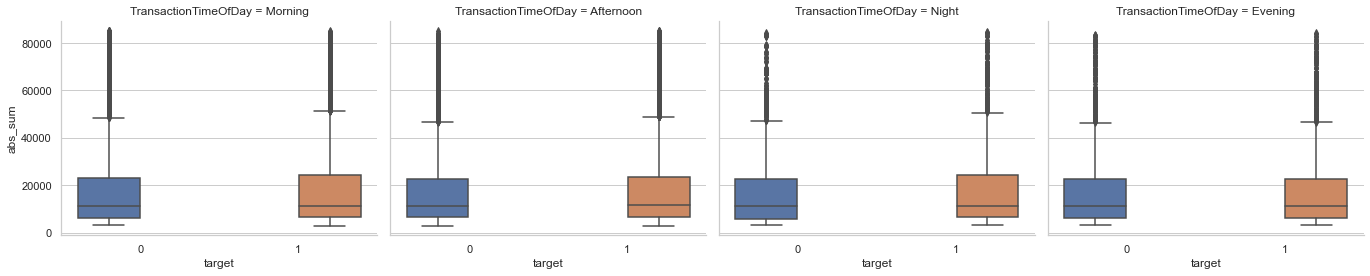

In [22]:
# same graph above but without outliers
graph2 = sns.catplot(x="target", y="abs_sum",
                hue="target", col="TransactionTimeOfDay",
                data=df_no_outliers, kind="box",
                height=4, aspect=1.2);

In [23]:
# creating dataframe to make anasysis on sums based on the copy of original dataset 
data_sum_analysis = data.copy()
data_sum_analysis['abs_sum'] = data_sum_analysis['sum'].apply(lambda x: abs(x))
data_sum_analysis = data_sum_analysis[['sum', 'abs_sum', 'client_id']].groupby('client_id').sum()

In [24]:
# creating number of transactions
data_sum_analysis = data_sum_analysis.join(data['client_id'].value_counts()).rename(columns={'client_id':'n_transactions'})

In [25]:
# finding amount of average transactions by divinding abs_sum on number of transactions
data_sum_analysis['average_transaction'] = data_sum_analysis['abs_sum']/data_sum_analysis['n_transactions']

In [26]:
# final representation of dataframe
data_sum_analysis = data_sum_analysis.join(data[['client_id', 'target']].drop_duplicates('client_id').set_index('client_id'))

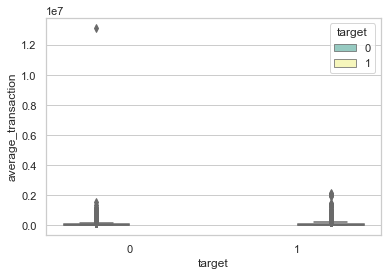

In [27]:
# graph which depicts distribution of average transactions by target
graph3 = sns.boxplot(x="target", y="average_transaction", hue="target",
                 data=data_sum_analysis, palette="Set3")

In [28]:
# deleting outlires from average transactions
iqr = data_sum_analysis['average_transaction'].describe()[-2] - data_sum_analysis['average_transaction'].describe()[-4]
high_lim = iqr*1.5 + data_sum_analysis['average_transaction'].describe()[-2]
low_lim = iqr*1/5 - data_sum_analysis['average_transaction'].describe()[-4]
df_no_outliers_avg = data_sum_analysis[(data_sum_analysis['average_transaction'] > low_lim) & (data_sum_analysis['average_transaction'] < high_lim)]

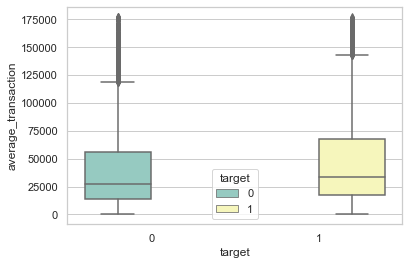

In [29]:
# this graph represents above distribution but without outliers
graph4 = sns.boxplot(x="target", y="average_transaction", hue="target",
                 data=df_no_outliers_avg, palette="Set3")

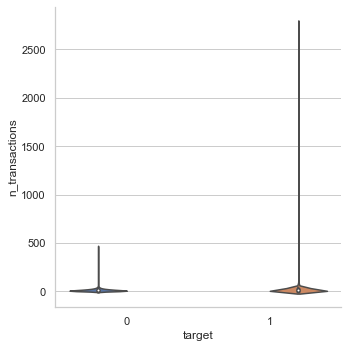

In [30]:
# graph shows how does number of transactions distributed by target
graph5 = sns.catplot(x="target", y="n_transactions", hue="target",
               data=data_sum_analysis, kind="violin")

In [31]:
# removing outliers from number of transactions 
iqr = data_sum_analysis['n_transactions'].describe()[-2] - data_sum_analysis['n_transactions'].describe()[-4]
high_lim = iqr*1.5 + data_sum_analysis['n_transactions'].describe()[-2]
low_lim = iqr*1/5 - data_sum_analysis['n_transactions'].describe()[-4]
df_no_outliers_n_transactions = data_sum_analysis[(data_sum_analysis['n_transactions'] > low_lim) & (data_sum_analysis['n_transactions'] < high_lim)]

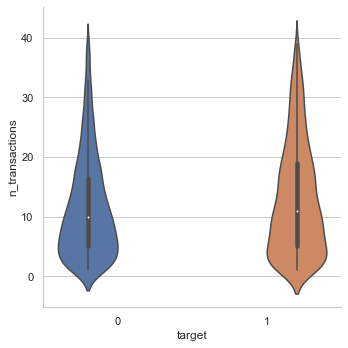

In [32]:
# representing number of transactions distribution by target without outliers, via violin plot
graph6 = sns.catplot(x="target", y="n_transactions", hue="target",
               data=df_no_outliers_n_transactions, kind="violin")

### Conclusion: According to all the graphs above, difference between all transactions and relation of transactions based on genders is negligible

## 3.2 Transaction distribution according to day of week and gender

In [33]:
# copying new dataframe from original 
day_of_week_distibution = data.copy()
day_of_week_distibution.drop(['client_id', 'code', 'type', 'sum'], axis=1, inplace=True)
day_of_week_distibution['day_of_week'] = day_of_week_distibution['datetime'].apply(lambda x: int(x.split()[0]) % 7)

# declaring new variables and assigning particular values, for man - 0, for woman - 1
number_man = sum(data['target'] == 0)
number_woman = sum(data['target'] == 1)

In [34]:
# dataframe consists of datetime, target and new column day_of_week which represents the order of the days
day_of_week_distibution.head()

,datetime,target,day_of_week
0,421 06:33:15,0,1
1,270 06:16:18,0,4
2,97 10:48:35,0,6
3,445 07:33:38,0,4
4,4 09:33:46,0,4


In [35]:
# ratio between transactions distributed by target completed in each dat of the week 
np.unique(day_of_week_distibution[day_of_week_distibution['target'] == 0]['day_of_week'], return_counts=True)[1] / number_man - np.unique(day_of_week_distibution[day_of_week_distibution['target'] == 1]['day_of_week'], return_counts=True)[1] / number_woman

array([-0.00148523, -0.00840523, -0.00994649,  0.00522179,  0.00700979,
        0.00400467,  0.0036007 ])

### Conclusion: Small deviation concludes that correlation between genders is almost absent and could be negligible

## 3.3 Working with code/type

### 3.3.1 Get the ratio of code/type according to gender

In [36]:
# data copy
data_to_classification = data.copy()
data_to_classification = data_to_classification.drop(['sum', 'datetime','client_id'], axis=1)

# get codes for men and women, and its occurrences
data_only_man = data_to_classification[['code', 'target']][data_to_classification['target'] == 0]
codes_only_man = np.unique(data_only_man['code'])
occur_only_man = np.unique(data_only_man['code'], return_counts=True)[1]
data_only_woman = data_to_classification[['code', 'target']][data_to_classification['target'] == 1]
codes_only_woman = np.unique(data_only_woman['code'])
occur_only_woman = np.unique(data_only_woman['code'], return_counts=True)[1]

codes_all = np.unique(data_to_classification['code'])

# get the number of transactions for men and women
number_man = sum(data_to_classification['target'] == 0)
number_woman = sum(data_to_classification['target'] == 1)

# count the frequency for codes according to gender(positive - 0, negative - 1, value - deflection)
in_both_codes = {}
only_man_codes = {}
only_woman_codes = {}
for code in codes_all:
    if code in codes_only_man and code in codes_only_woman:
        in_both_codes[code] = round(100 * occur_only_man[np.where(codes_only_man == code)[0][0]] / number_man - 100 * occur_only_woman[np.where(codes_only_woman == code)[0][0]] / number_woman, 4)
    elif code in codes_only_man:
        only_man_codes[code] = round(100 * occur_only_man[np.where(codes_only_man == code)[0][0]] / number_man, 4)
    else:
        only_woman_codes[code] = round(100 * occur_only_woman[np.where(codes_only_woman == code)[0][0]] / number_woman, 4)

In [37]:
# get types for man and woman, and its occurrences
data_only_man = data_to_classification[['type', 'target']][data_to_classification['target'] == 0]
types_only_man = np.unique(data_only_man['type'])
occur_only_man = np.unique(data_only_man['type'], return_counts=True)[1]
data_only_woman = data_to_classification[['type', 'target']][data_to_classification['target'] == 1]
types_only_woman = np.unique(data_only_woman['type'])
occur_only_woman = np.unique(data_only_woman['type'], return_counts=True)[1]

types_all = np.unique(data_to_classification['type'])

# count the frequency for types according to gender(positive - 0, negative - 1, value - deflection)
in_both_types = {}
only_man_types = {}
only_woman_types = {}
for type in types_all:
    if type in types_only_man and type in types_only_woman:
        in_both_types[type] = round(100 * occur_only_man[np.where(types_only_man == type)[0][0]] / number_man - 100 * occur_only_woman[np.where(types_only_woman == type)[0][0]] / number_woman, 4)
    elif type in types_only_man:
        only_man_types[type] = round(100 * occur_only_man[np.where(types_only_man == type)[0][0]] / number_man, 4)
    else:
        only_woman_types[type] = round(100 * occur_only_woman[np.where(types_only_woman == type)[0][0]] / number_woman, 4)

In [38]:
# if code or type occur only for women then do it negative
for key, value in only_woman_codes.items():
    only_woman_codes[key] = value * -1
for key, value in only_woman_types.items():
    only_woman_types[key] = value * -1

# concat all dicts ith code
codes_merged = in_both_codes.copy()
codes_merged.update(only_man_codes)
codes_merged.update(only_woman_codes)

# concat all dicts ith type
types_merged = in_both_types.copy()
types_merged.update(only_man_types)
types_merged.update(only_woman_types)

In [39]:
# creating dataframe from dictionary based on previously prepared dictionary
df_types_merged = pd.DataFrame.from_dict(types_merged, orient='index').reset_index()
df_types_merged['values'] = df_types_merged.iloc[:,1]
df_types_merged = df_types_merged.rename(columns={"index": "type"})

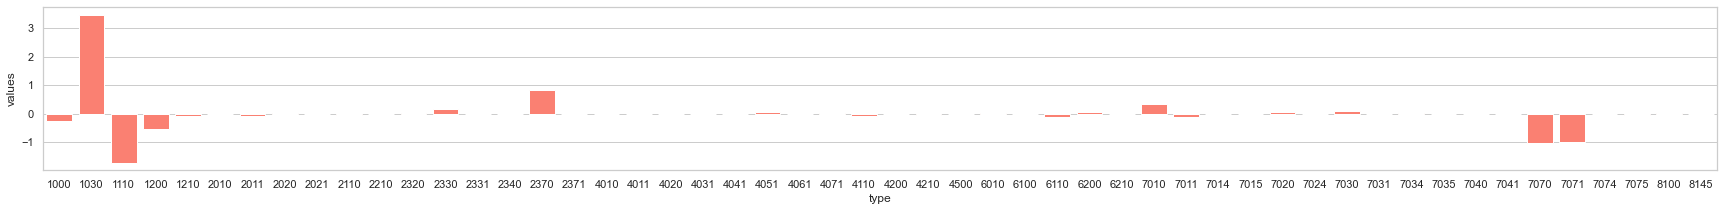

In [40]:
# plotting graph which represents values deviation between genders according to types from types table 
plt.figure(figsize=(30,3))
ax = sns.barplot(x="type", y="values", data=df_types_merged,
                 color="salmon", saturation=2.5)

In [41]:
# creating dataframe from dictionary which consist of values and codes prepared on difference of genders
df_codes_merged = pd.DataFrame.from_dict(codes_merged, orient='index').reset_index()
df_codes_merged['values'] = df_codes_merged.iloc[:,1]
df_codes_merged = df_codes_merged.rename(columns={"index": "code"})

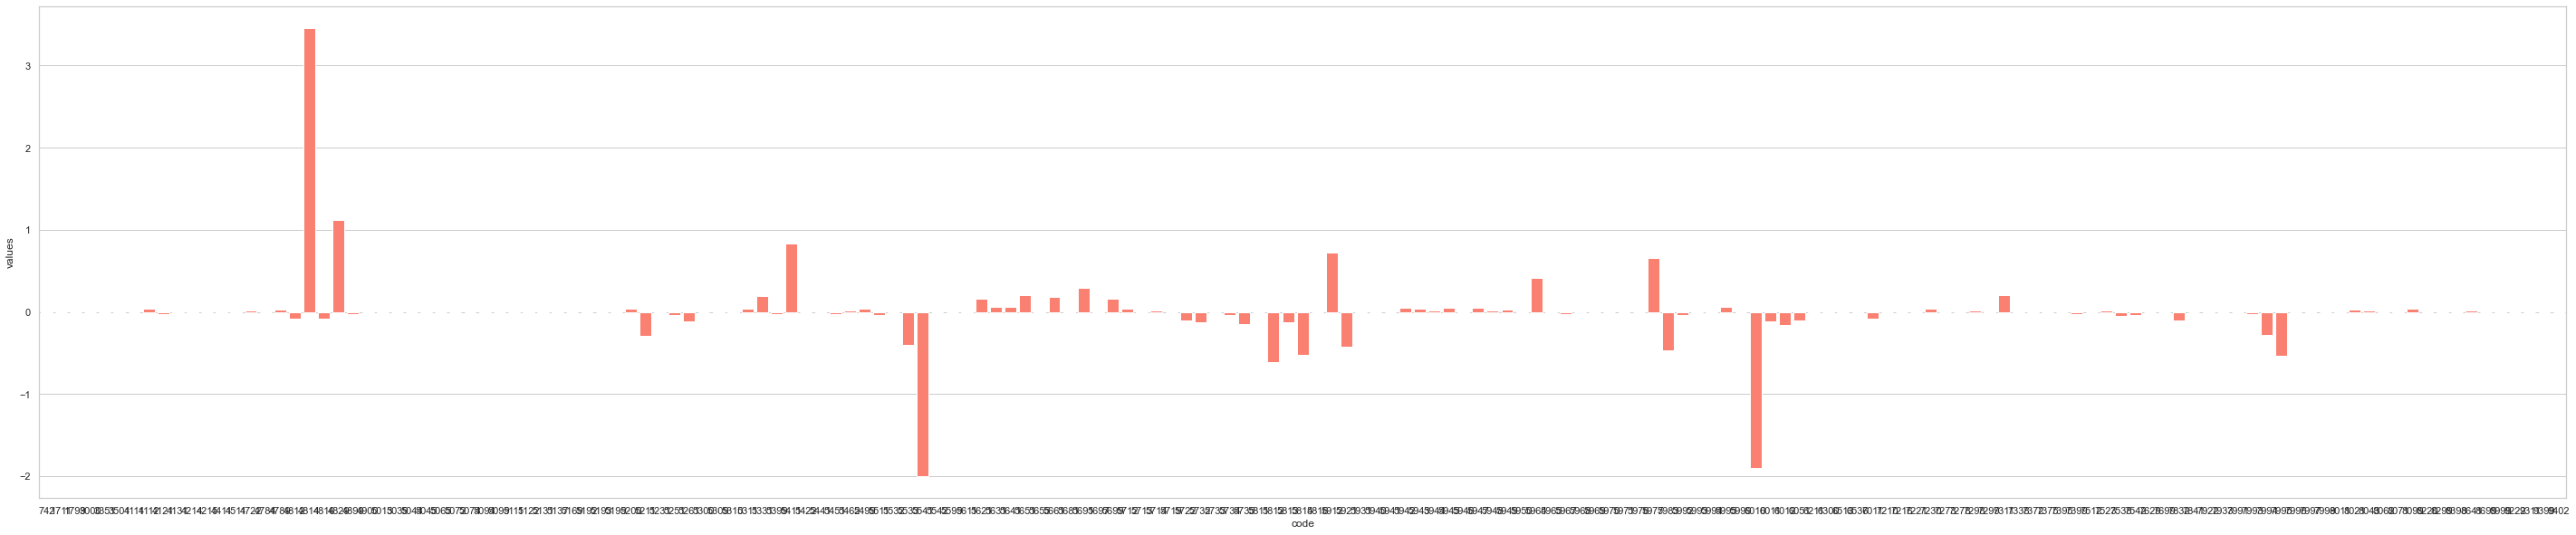

In [42]:
# plotting graph which represents values deviation between genders accordong to codes from codes table 
plt.figure(figsize=(50,10))
ax1 = sns.barplot(x="code", y="values", data=df_codes_merged,
                 color="salmon", saturation=2.5)

**Conclusion: The deviation values are too small, with a few exceptions, to indicate that there is a relationship between the type or code of the transaction and the gender of the client.**

### 3.3.2 Trying to predict gender according to the most characteristic transactions

In [43]:
data_exp = data.copy()
data_exp = data_exp.drop(['datetime', 'sum'], axis=1)

In [44]:
list_of_corr_x_codes = []
list_of_corr_y_codes = []

n_0 = sum(data['target'] == 0)
n_1 = sum(data['target'] == 1)

for code in codes['code'].to_list():
    nums = list(np.unique(data[data['code'] == code]['target'], return_counts=True)[0])
    corr = list(np.unique(data[data['code'] == code]['target'], return_counts=True)[1])
    if len(nums) == 0:
        continue
        
    if len(nums) == 1:
        if nums == [0]:
            corr.append(0)
        if nums == [1]:
            corr = [0, corr[0]]
    list_of_corr_x_codes.append(corr[0]/n_0)
    list_of_corr_y_codes.append(corr[1]/n_1)

[(0.0, 0.01), (0.0, 0.01)]

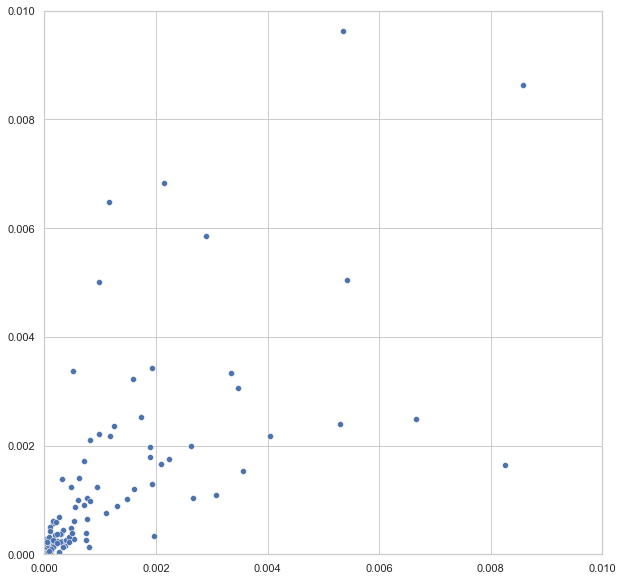

In [45]:
# graph represents relation of each point to axes, where axes are targets
plt.rcParams["figure.figsize"] = (10,10)
sns.scatterplot(x=list_of_corr_x_codes, y=list_of_corr_y_codes).set(xlim=(0, 0.01), ylim=(0,0.01))

In [46]:
res_codes = [x/y for x ,y in zip(list_of_corr_x_codes, list_of_corr_y_codes)]
dict_codes = {}
for code , result in zip(codes['code'].to_list(), res_codes):
    if math.isinf(result):
        dict_codes[code] = -1 #man
    elif result == 0: 
        dict_codes[code] = 1 #woman
    else:
        if result > 2:
            dict_codes[code] = -1
        elif result < 0.4:
            dict_codes[code] = 1
        else:
            dict_codes[code] = 0

In [47]:
list_of_corr_x_types = []
list_of_corr_y_types = []

n_0 = sum(data['target'] == 0)
n_1 = sum(data['target'] == 1)

for type in types['type'].to_list():
    nums = list(np.unique(data[data['type'] == type]['target'], return_counts=True)[0])
    corr = list(np.unique(data[data['type'] == type]['target'], return_counts=True)[1])
    if len(nums) == 0:
        continue
        
    if len(nums) == 1:
        if nums == [0]:
            corr.append(0)
        if nums == [1]:
            corr = [0, corr[0]]
    list_of_corr_x_types.append(corr[0]/n_0)
    list_of_corr_y_types.append(corr[1]/n_1)
    
res_types = [x/y for x ,y in zip(list_of_corr_x_types, list_of_corr_y_types)]
dict_types = {}
for type , result in zip(types['type'].to_list(), res_types):
    if math.isinf(result):
        dict_types[type] = -1 #man
    elif result == 0: 
        dict_types[type] = 1 #woman
    else:
        if result > 2:
            dict_types[type] = -1
        elif result < 0.4:
            dict_types[type] = 1
        else:
            dict_types[type] = 0

[(0.0, 0.01), (0.0, 0.01)]

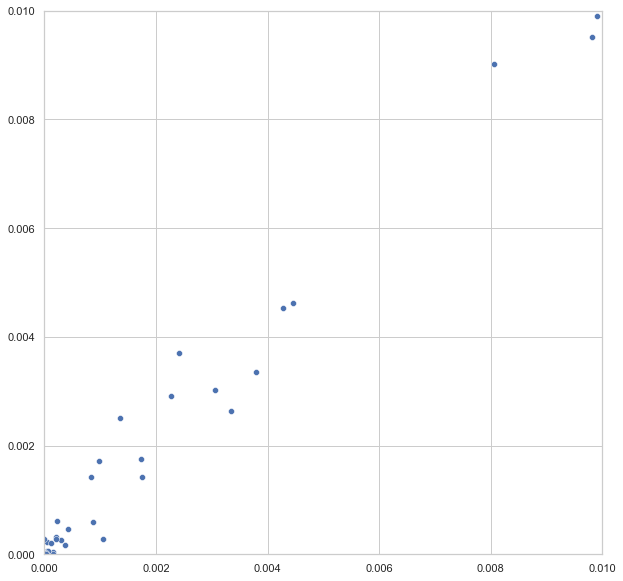

In [48]:
# graph represents relation of each point to axes, where axes are targets according to types
plt.rcParams["figure.figsize"] = (10,10)
sns.scatterplot(x=list_of_corr_x_types, y=list_of_corr_y_types).set(xlim=(0, 0.01), ylim=(0,0.01))

#### Conclusion: We will use the above data in Feature Engineering to try to determine the gender based on the code and type of transactions.

# 4. Feature engineering

## 4.1 Data to classification

In [49]:
data_to_classification = data.copy()
#data_to_classification = data_to_classification.drop(['target'], axis=1)
data_to_classification['code'] = data_to_classification['code'].apply(lambda x: codes_merged.get(x))
data_to_classification['type'] = data_to_classification['type'].apply(lambda x: types_merged.get(x))
data_to_classification['avg_trans'] = data_to_classification['sum'].apply(lambda x: abs(x))
data_to_classification['codetype'] = data_to_classification['code'].add(data_to_classification['type'])

data_to_classification['n_trans'] = 1
data_to_classification = data_to_classification.groupby('client_id').aggregate({ 'sum' : 'mean', 'codetype':'mean',
                                                                                 'type':'mean', 'code':'mean',
                                                                                'n_trans' : 'sum', 'target': 'max',
                                                                               'avg_trans':'mean'})

rfmData = data.copy()
rfmData.drop_duplicates(inplace = True)
rfmData[['day', 'datetime']] = rfmData['datetime'].str.split(' ', 1, expand=True)
rfmData2 = rfmData.copy()
rfmData2['monetary'] = rfmData2['sum'].apply(lambda x: float(abs(x)))
groupedRfm = rfmData2.groupby('client_id').sum().drop(['code', 'type', 'target', 'sum'], axis = 1)
groupedRfm['recency'] = rfmData2.groupby('client_id').max()['day'].apply(lambda x: 457 - int(x)).to_list()
groupedRfm['frequency'] = rfmData2.groupby('client_id').count()['day'].to_list()

groupedRfm["recencyScore"] = pd.cut(groupedRfm["recency"],
                                       bins=[0, 
                                         np.percentile(groupedRfm["recency"], 25), 
                                             np.percentile(groupedRfm["recency"], 50), 
                                             np.percentile(groupedRfm["recency"], 75), 
                                             groupedRfm["recency"].max()], 
                                       labels=[4, 3, 2, 1]).astype("int")
groupedRfm["frequencyScore"] = pd.cut(groupedRfm["frequency"], 
                                       bins=[0, 
                                         np.percentile(groupedRfm["frequency"], 25), 
                                             np.percentile(groupedRfm["frequency"], 50), 
                                             np.percentile(groupedRfm["frequency"], 75), 
                                             groupedRfm["frequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
groupedRfm["monetaryScore"] = pd.cut(groupedRfm["monetary"], 
                                       bins=[0, 
                                         np.percentile(groupedRfm["monetary"], 25), 
                                             np.percentile(groupedRfm["monetary"], 50), 
                                             np.percentile(groupedRfm["monetary"], 75), 
                                             groupedRfm["monetary"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
groupedRfm['rfmScore'] = groupedRfm["monetaryScore"] + groupedRfm["recencyScore"] + groupedRfm["frequencyScore"]

data_to_classification = data_to_classification.join(groupedRfm[['rfmScore', 'monetaryScore']])

In [50]:
data_to_classification

,sum,codetype,type,code,n_trans,target,avg_trans,rfmScore,monetaryScore
client_id,,,,,,,,,
22899,5649.726667,-0.382978,-0.069789,-0.313189,9,1,13315.786667,4,1
27914,18528.802500,3.050475,1.826725,1.223750,4,1,20774.722500,5,1
28753,-199215.406923,0.943738,-0.072192,1.015931,13,0,302873.057692,9,4
38084,26672.910000,0.829392,0.104604,0.724788,26,0,108082.036923,10,4
49793,-65829.236667,1.218857,0.201510,1.017348,21,1,68395.997619,10,4
...,...,...,...,...,...,...,...,...,...
99900908,-14410.426000,-1.247660,-1.377820,0.130160,5,0,14410.426000,5,1
99911226,-55632.494167,-0.171292,-0.719275,0.547983,12,0,55632.494167,9,3
99967537,-336887.370000,-0.132700,-0.019900,-0.112800,1,1,336887.370000,6,2


## 4.2 Data to classification scaled

In [51]:
from sklearn import preprocessing
data_to_classification_scaled = data_to_classification.copy()
data_to_classification_scaled['sum'] = preprocessing.StandardScaler().fit(data_to_classification['sum'].to_numpy().reshape(-1, 1)).transform(data_to_classification['sum'].to_numpy().reshape(-1, 1))
data_to_classification_scaled['avg_trans'] = preprocessing.StandardScaler().fit(data_to_classification['avg_trans'].to_numpy().reshape(-1, 1)).transform(data_to_classification['avg_trans'].to_numpy().reshape(-1, 1))
data_to_classification_scaled['n_trans'] = preprocessing.StandardScaler().fit(data_to_classification['n_trans'].to_numpy().reshape(-1, 1)).transform(data_to_classification['n_trans'].to_numpy().reshape(-1, 1))
data_to_classification_scaled['rfmScore'] = preprocessing.StandardScaler().fit(data_to_classification['rfmScore'].to_numpy().reshape(-1, 1)).transform(data_to_classification['rfmScore'].to_numpy().reshape(-1, 1))
data_to_classification_scaled['monetaryScore'] = preprocessing.StandardScaler().fit(data_to_classification['monetaryScore'].to_numpy().reshape(-1, 1)).transform(data_to_classification['monetaryScore'].to_numpy().reshape(-1, 1))

In [52]:
data_to_classification_scaled.head()

,sum,codetype,type,code,n_trans,target,avg_trans,rfmScore,monetaryScore
client_id,,,,,,,,,
22899,0.276787,-0.382978,-0.069789,-0.313189,-0.150982,1,-0.303329,-1.687562,-1.341641
27914,0.377899,3.050475,1.826725,1.223750,-0.271047,1,-0.269117,-1.197063,-1.341641
28753,-1.331596,0.943738,-0.072192,1.015931,-0.054930,0,1.024804,0.764933,1.341641
38084,0.441838,0.829392,0.104604,0.724788,0.257239,0,0.131342,1.255432,1.341641
49793,-0.284390,1.218857,0.201510,1.017348,0.137174,1,-0.050689,1.255432,1.341641


## 4.3 Data_exp_grouped

In [53]:
data_exp = data.copy()
data_exp = data_exp.drop(['datetime', 'sum'], axis=1)

In [54]:
data_exp['codes_man'] = data_exp['code'].apply(lambda x: 1 if dict_codes.get(x) == -1 else 0)
data_exp['codes_undef'] = data_exp['code'].apply(lambda x: 1 if dict_codes.get(x) == 0 else 0)
data_exp['codes_woman'] = data_exp['code'].apply(lambda x: 1 if dict_codes.get(x) == 1 else 0)

data_exp['types_man'] = data_exp['type'].apply(lambda x: 1 if dict_types.get(x) == -1 else 0)
data_exp['types_undef'] = data_exp['type'].apply(lambda x: 1 if dict_types.get(x) == 0 else 0)
data_exp['types_woman'] = data_exp['type'].apply(lambda x: 1 if dict_types.get(x) == 1 else 0)

In [55]:
data_exp_grouped = data_exp.groupby('client_id').agg({'target':'max', 'codes_man':'sum', 'codes_undef':'sum', 'codes_woman':'sum',
                                                     'types_man':'sum', 'types_undef':'sum', 'types_woman':'sum'})

In [56]:
predicted_codes = []
for row in data_exp_grouped.iterrows():
    if row[1][2] > row[1][3] and row[1][2] > row[1][1]:
        predicted_codes.append(0.5)
        continue
    
    if row[1][3] > row[1][1]:
        predicted_codes.append(1)
    elif row[1][3] < row[1][1]:
        predicted_codes.append(0)
    else:
        predicted_codes.append(0.5)

predicted_types = []
for row in data_exp_grouped.iterrows():
    if row[1][5] > row[1][6] and row[1][5] > row[1][4]:
        predicted_types.append(0.5)
        continue
    
    if row[1][6] > row[1][4]:
        predicted_types.append(1)
    elif row[1][6] < row[1][4]:
        predicted_types.append(0)
    else:
        predicted_types.append(0.5)

data_exp_grouped['res_codes'] = predicted_codes
data_exp_grouped['res_types'] = predicted_types

In [57]:
data_exp_grouped.head()

,target,codes_man,codes_undef,codes_woman,types_man,types_undef,types_woman,res_codes,res_types
client_id,,,,,,,,,
22899,1,0,3,6,0,1,1,1.0,1.0
27914,1,0,3,1,0,1,2,0.5,1.0
28753,0,2,8,2,0,3,3,0.5,1.0
38084,0,0,17,9,0,11,6,0.5,0.5
49793,1,0,7,14,0,2,6,1.0,1.0


target - gender 
 
codes_man - number of transactions for male(code). 
 
codes_woman - number of transactions for female(code). 
 
codes_undefined - number of transactions of undefined(code). 
 
types_man - number of transactions for male(type). 
 
types_woman - number of transactions for female(type). 
 
types_undefined - number of transactions of undefined(types). 
 
res_codes - result of transactions either male or female codes 
 
res_types - result of transactions either male or female types

## 4.4 Trying to predict gender according to transaction codes/types

In [58]:
data_exp_grouped_only_strong = data_exp_grouped[(data_exp_grouped['res_codes'] != 0.5) & (data_exp_grouped['res_types'] != 0.5) & (data_exp_grouped['res_codes'] == data_exp_grouped['res_types'])]
sum(data_exp_grouped_only_strong['target'] == data_exp_grouped_only_strong['res_codes']) / len(data_exp_grouped_only_strong)

0.5185537583254044

**The result is approximately 0.52 which allows us to conclude that value is small to talk about the appearance of correlation. Answer could be biased**

## 4.5 Data_c (combined)

In [59]:
# assigning additional features
data_c = data.groupby('client_id') \
                    .apply(lambda x: x[['code']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

In [60]:
# combining previous datasets
data_c = data_c.join(data_exp_grouped.drop('target', axis=1))
data_c = data_c.join(data.groupby('client_id').agg({'sum':'mean'}))
data_c = data_c.join(data_to_classification.drop(['sum'], axis=1))

In [61]:
data_c.head()

,742,1711,1799,3000,3351,3501,4111,4112,4121,4131,...,res_types,sum,codetype,type,code,n_trans,target,avg_trans,rfmScore,monetaryScore
client_id,,,,,,,,,,,,,,,,,,,,,
22899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5649.726667,-0.382978,-0.069789,-0.313189,9,1,13315.786667,4,1
27914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,18528.802500,3.050475,1.826725,1.223750,4,1,20774.722500,5,1
28753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-199215.406923,0.943738,-0.072192,1.015931,13,0,302873.057692,9,4
38084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,26672.910000,0.829392,0.104604,0.724788,26,0,108082.036923,10,4
49793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-65829.236667,1.218857,0.201510,1.017348,21,1,68395.997619,10,4


data_c: two merged data_frames(data_exp_grouped, Data to classification) with exctra features

# 5. Model Selection

## Import models & metrics

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

## 5.1 Estimate best parameters and accuracy for 10 different models and 3 datasets

In [63]:
def parameter_selector(data, model_name, rturn=False):
    """
    For given data and model name(optional), estimate best parameters and return model(optional, only for unique model)

    All models - 'all'
    KNeighborsClassifier - 'knn'
    DecisionTreeClassifier - 'dtree'
    RandomForestClassifier - 'rand_forest'
    GradientBoostingClassifier - 'gboost'
    AdaBoostClassifier - 'adaboost'
    Linear SVM - 'linear_svm'
    RBF - 'rbf'
    MLPClassifier - 'mlp'
    QuadraticDiscriminantAnalysis - 'qda'
    GaussianNB - 'gausnb'
    """


    X = data.drop('target', axis=1)
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    
    if model_name == 'all' or model_name == 'knn':
        model = KNeighborsClassifier(n_jobs=-1)
        params = {
            'n_neighbors':[i for i in range(3, 15, 2)],
            'metric':['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'cosine']
        }
        
        gsearch = GridSearchCV(estimator = model, 
        param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
        gsearch.fit(X_train, y_train)
        print('knn')
        print(gsearch.best_params_)
        print(gsearch.best_score_)
        print(gsearch.score(X_test, y_test))
        print(confusion_matrix(y_test, gsearch.predict(X_test)))
        print('-'*60)
        if model_name != 'all' and rturn == True:
            return gsearch
    
    if model_name == 'all' or model_name == 'dtree':
        model = DecisionTreeClassifier(random_state=42)
        params = {
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [i for i in range(1, 15, 2)]
        }
        
        gsearch = GridSearchCV(estimator = model, 
        param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
        gsearch.fit(X_train, y_train)
        print('dtree')
        print(gsearch.best_params_)
        print(gsearch.best_score_)
        print(gsearch.score(X_test, y_test))
        print(confusion_matrix(y_test, gsearch.predict(X_test)))
        print('-'*60)
        if model_name != 'all' and rturn == True:
            return gsearch
        
    if model_name == 'all' or model_name == 'rand_forest':
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        params = {
            'n_estimators' : [i for i in range(10, 100, 10)],
            'max_depth' : [i for i in range(1, 15, 2)],
            'criterion' : ['gini', 'entropy']
        }
        
        gsearch = GridSearchCV(estimator = model, 
        param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
        gsearch.fit(X_train, y_train)
        print('rand_forest')
        print(gsearch.best_params_)
        print(gsearch.best_score_)
        print(gsearch.score(X_test, y_test))
        print(confusion_matrix(y_test, gsearch.predict(X_test)))
        print('-'*60)
        if model_name != 'all' and rturn == True:
            return gsearch
    
    if model_name == 'all' or model_name == 'linear_svm':
        model = SVC(kernel='linear', random_state=42)
        params = {
            'C' : [0.1, 0.5, 1, 2, 5],
            'max_iter': [100, 500, 1000, 2000]
        }
        
        gsearch = GridSearchCV(estimator = model, 
        param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
        gsearch.fit(X_train, y_train)
        print('linear_svm')
        print(gsearch.best_params_)
        print(gsearch.best_score_)
        print(gsearch.score(X_test, y_test))
        print(confusion_matrix(y_test, gsearch.predict(X_test)))
        print('-'*60)
        if model_name != 'all' and rturn == True:
            return gsearch
    
    if model_name == 'all' or model_name == 'rbf':
        model = SVC(random_state=42)
        params = {
            'C' : [0.1, 0.5, 1, 2, 5],
            'max_iter': [100, 500, 1000, 2000],
            'gamma' : [0.1, 0.5, 1, 2]
        }
        
        gsearch = GridSearchCV(estimator = model, 
        param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
        gsearch.fit(X_train, y_train)
        print('rbf')
        print(gsearch.best_params_)
        print(gsearch.best_score_)
        print(gsearch.score(X_test, y_test))
        print(confusion_matrix(y_test, gsearch.predict(X_test)))
        print('-'*60)
        if model_name != 'all' and rturn == True:
            return gsearch
    
    if model_name == 'all' or model_name == 'mlp':
        model = MLPClassifier(alpha=0.01, max_iter=1000, random_state=42)
        params = {
            'max_iter': [100, 500, 1000, 2000],
            'alpha' : [0.1, 0.5, 1, 2]
        }
        
        gsearch = GridSearchCV(estimator = model, 
        param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
        gsearch.fit(X_train, y_train)
        print('mlp')
        print(gsearch.best_params_)
        print(gsearch.best_score_)
        print(gsearch.score(X_test, y_test))
        print(confusion_matrix(y_test, gsearch.predict(X_test)))
        print('-'*60)
        if model_name != 'all' and rturn == True:
            return gsearch
    
    if model_name == 'all' or model_name == 'adaboost':
        model = AdaBoostClassifier(n_estimators=3, learning_rate=1, random_state=42)
        params = {
            'n_estimators': [i for i in range(1, 30, 2)],
            'learning_rate' : [0.01, 0.1, 0.5, 1, 2]
        }
        
        gsearch = GridSearchCV(estimator = model, 
        param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
        gsearch.fit(X_train, y_train)
        print('adaboost')
        print(gsearch.best_params_)
        print(gsearch.best_score_)
        print(gsearch.score(X_test, y_test))
        print(confusion_matrix(y_test, gsearch.predict(X_test)))
        print('-'*60)
        if model_name != 'all' and rturn == True:
            return gsearch
    
    if model_name == 'all' or model_name == 'gausnb':
        model = GaussianNB(var_smoothing=1e-9)
        params = {
            'var_smoothing': [1e-9, 1e-7, 1e-5, 1e-3, 1e-1]
        }
        
        gsearch = GridSearchCV(estimator = model, 
        param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
        gsearch.fit(X_train, y_train)
        print('gausnb')
        print(gsearch.best_params_)
        print(gsearch.best_score_)
        print(gsearch.score(X_test, y_test))
        print(confusion_matrix(y_test, gsearch.predict(X_test)))
        print('-'*60)
        if model_name != 'all' and rturn == True:
            return gsearch
    
    if model_name == 'all' or model_name == 'qda':
        model = QuadraticDiscriminantAnalysis(reg_param=0)
        params = {
            'reg_param': [i/10 for i in range(1, 10, 1)],
            'store_covariance' : [True, False]
        }
        
        gsearch = GridSearchCV(estimator = model, 
        param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
        gsearch.fit(X_train, y_train)
        print('qda')
        print(gsearch.best_params_)
        print(gsearch.best_score_)
        print(gsearch.score(X_test, y_test))
        print(confusion_matrix(y_test, gsearch.predict(X_test)))
        print('-'*60)
        if model_name != 'all' and rturn == True:
            return gsearch
    
    if model_name == 'all' or model_name == 'gboost':
        model = GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=6)
        params = {
            'n_estimators': [10, 50, 100, 200, 500],
            'max_depth' : [i for i in range(1, 5, 2)]
        }
        
        gsearch = GridSearchCV(estimator = model, 
        param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
        gsearch.fit(X_train, y_train)
        print('gboost')
        print(gsearch.best_params_)
        print(gsearch.best_score_)
        print(gsearch.score(X_test, y_test))
        print(confusion_matrix(y_test, gsearch.predict(X_test)))
        print('-'*60)
        if model_name != 'all' and rturn == True:
            return gsearch

In [67]:
for dataset in [data_to_classification, data_c, data_exp_grouped]:
    print('+'*60)
    print('+'*60)
    parameter_selector(dataset, 'all')
    print('+'*60)
    print('+'*60)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
all
{'metric': 'euclidean', 'n_neighbors': 3}
0.527354262335308
0.5093863075196409
[[497 328]
 [384 291]]
------------------------------------------------------------
all
{'criterion': 'entropy', 'max_depth': 5}
0.6099133160733332
0.610270707070707
[[646 179]
 [420 255]]
------------------------------------------------------------
all
{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 40}
0.6275886244247362
0.6177903479236813
[[658 167]
 [421 254]]
------------------------------------------------------------
all
{'C': 0.5, 'max_iter': 1000}
0.5548742807637801
0.572616835016835
[[823   2]
 [669   6]]
------------------------------------------------------------
all
{'C': 0.5, 'gamma': 1, 'max_iter': 100}
0.5036000620959382
0.5006096520763188
[[817   8]
 [674   1]]
------------------------------------------------------------
all
{'alpha': 2, 'max_iter': 100}
0.53807

### Conclusion: Datasets data_to_classification and data_exp_grouped showed poor accuracy and roc/auc scores so we will continue to work only with data_c dataset. Among 10 models we define 5 which showed good accuracy.

## 5.2 Detailed parameter estimation for perspective models

In [64]:
def evaluate_model(test, real):
    return classification_report(test, real)

def plotROC(model, X_test, y_test, model_name):
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot([0,1],[0,1],'k--') 
    plt.plot(fpr,tpr, label='Knn') 
    plt.xlabel('False positive rate') 
    plt.ylabel('True positive rate') 
    plt.title(f'{model_name} ROC curve') 
    plt.show()

### 5.2.1 KNN

In [65]:
X = data_c.drop('target', axis=1)
y = data_c['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Best parameters are:  {'leaf_size': 10, 'metric': 'cosine', 'n_neighbors': 13} 

Best score: 0.5319148083789453 

Current score: 0.5336897867564534 

Confusion matrix: [[574 251]
 [437 238]] 

Metrics for model evaluation:
               precision    recall  f1-score   support

           0       0.57      0.70      0.63       825
           1       0.49      0.35      0.41       675

    accuracy                           0.54      1500
   macro avg       0.53      0.52      0.52      1500
weighted avg       0.53      0.54      0.53      1500
 



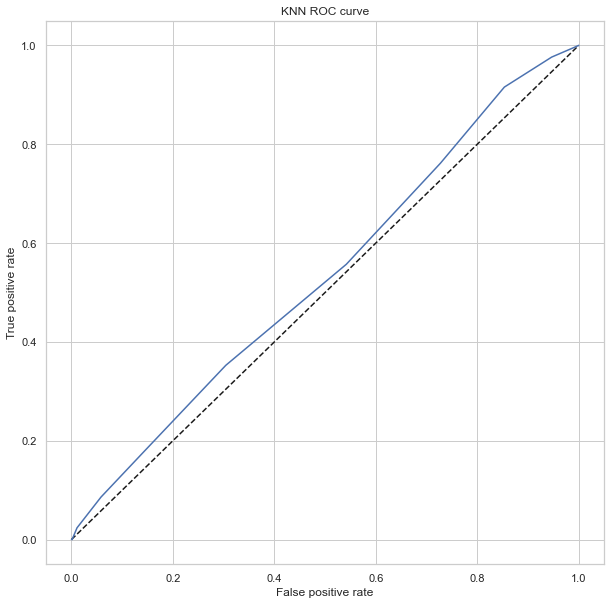

In [66]:
knn_model = KNeighborsClassifier(n_jobs=-1)
params = {
    'n_neighbors':[12,13,14],
    'metric':['cosine'],
    'leaf_size' : [i for i in range(10, 110, 10)],
}
        
gsearch = GridSearchCV(estimator = knn_model, 
param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
gsearch.fit(X_train, y_train)
knn_model = gsearch
print('Best parameters are: ', gsearch.best_params_, '\n')
print('Best score:', gsearch.best_score_, '\n')
print('Current score:', gsearch.score(X_test, y_test), '\n')
print('Confusion matrix:', confusion_matrix(y_test, gsearch.predict(X_test)), '\n')
print('Metrics for model evaluation:\n', evaluate_model(y_test, gsearch.predict(X_test)), '\n')
plotROC(knn_model, X_test, y_test, 'KNN')

### 5.2.2 Decision Tree Classifier

In [67]:
X = data_c.drop('target', axis=1)
y = data_c['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Best parameters are:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': None} 

Best score: 0.6626232529257703 

Current score: 0.6377185185185185 

Confusion matrix: [[657 168]
 [387 288]] 

Metrics for model evaluation:
               precision    recall  f1-score   support

           0       0.63      0.80      0.70       825
           1       0.63      0.43      0.51       675

    accuracy                           0.63      1500
   macro avg       0.63      0.61      0.61      1500
weighted avg       0.63      0.63      0.62      1500
 



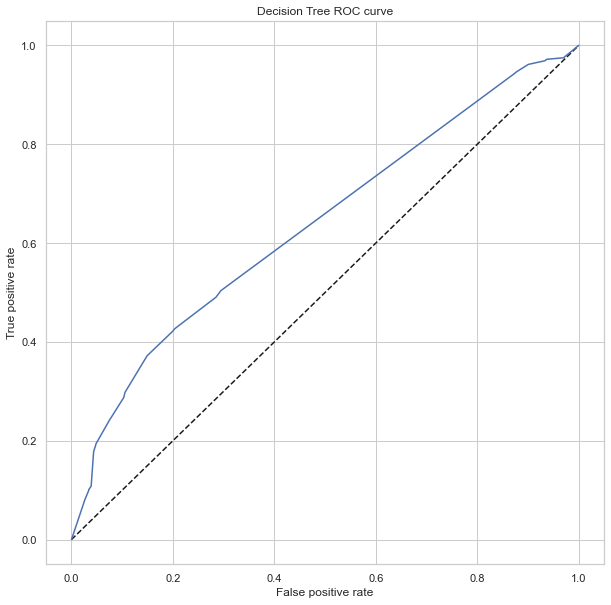

In [68]:
dtree_model = DecisionTreeClassifier(random_state=42)
params = {
    'criterion' : ['entropy'],
    'max_depth' : [6,7,8],
    'max_features' : [1,2,None,'sqrt', 'log2']
}
        
gsearch = GridSearchCV(estimator = dtree_model, 
param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
gsearch.fit(X_train, y_train)
dtree_model = gsearch
# print(gsearch.best_params_)
# print(gsearch.best_score_)
# print(gsearch.score(X_test, y_test))
# print(confusion_matrix(y_test, gsearch.predict(X_test)))
print('Best parameters are: ', gsearch.best_params_, '\n')
print('Best score:', gsearch.best_score_, '\n')
print('Current score:', gsearch.score(X_test, y_test), '\n')
print('Confusion matrix:', confusion_matrix(y_test, gsearch.predict(X_test)), '\n')
print('Metrics for model evaluation:\n', evaluate_model(y_test, gsearch.predict(X_test)), '\n')
plotROC(dtree_model, X_test, y_test, 'Decision Tree')

We have tested different parameters and features for KNN and Decision Tree. In average we have got the score around 60 for Decision Tree and 54 for KNN. As we have understood, there aren't any special regularities in dataset between males and females that the reason why our score is so low. We also can see the difference between scores of KNN and Decision Tree, according to this it's obvious that logical algorithm shows better result than geometrical

### 5.2.3 Random Forest

In [69]:
X = data_c.drop('target', axis=1)
y = data_c['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Best parameters are:  {'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 86} 

Best score: 0.7160608139575644 

Current score: 0.6911685746352413 

Confusion matrix: [[693 132]
 [404 271]] 

Metrics for model evaluation:
               precision    recall  f1-score   support

           0       0.63      0.84      0.72       825
           1       0.67      0.40      0.50       675

    accuracy                           0.64      1500
   macro avg       0.65      0.62      0.61      1500
weighted avg       0.65      0.64      0.62      1500
 



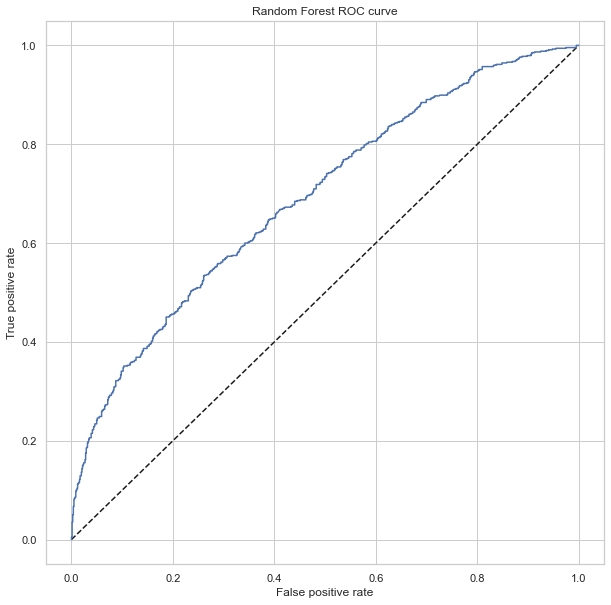

In [70]:
rand_forest_model = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'n_estimators' : [i for i in range(86, 94, 2)],
    'max_depth' : [12,13,14],
    'criterion' : ['entropy']
}
        
gsearch = GridSearchCV(estimator = rand_forest_model, 
param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
gsearch.fit(X_train, y_train)
rand_forest_model = gsearch
# print(gsearch.best_params_)
# print(gsearch.best_score_)
# print(gsearch.score(X_test, y_test))
# print(confusion_matrix(y_test, gsearch.predict(X_test)))
print('Best parameters are: ', gsearch.best_params_, '\n')
print('Best score:', gsearch.best_score_, '\n')
print('Current score:', gsearch.score(X_test, y_test), '\n')
print('Confusion matrix:', confusion_matrix(y_test, gsearch.predict(X_test)), '\n')
print('Metrics for model evaluation:\n', evaluate_model(y_test, gsearch.predict(X_test)), '\n')
plotROC(rand_forest_model, X_test, y_test, 'Random Forest')

### 5.2.4 AdaBoost Classifier

In [71]:
X = data_c.drop('target', axis=1)
y = data_c['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Best parameters are:  {'learning_rate': 1, 'n_estimators': 25} 

Best score: 0.7116990750709846 

Current score: 0.6929571268237935 

Confusion matrix: [[669 156]
 [374 301]] 

Metrics for model evaluation:
               precision    recall  f1-score   support

           0       0.64      0.81      0.72       825
           1       0.66      0.45      0.53       675

    accuracy                           0.65      1500
   macro avg       0.65      0.63      0.62      1500
weighted avg       0.65      0.65      0.63      1500
 



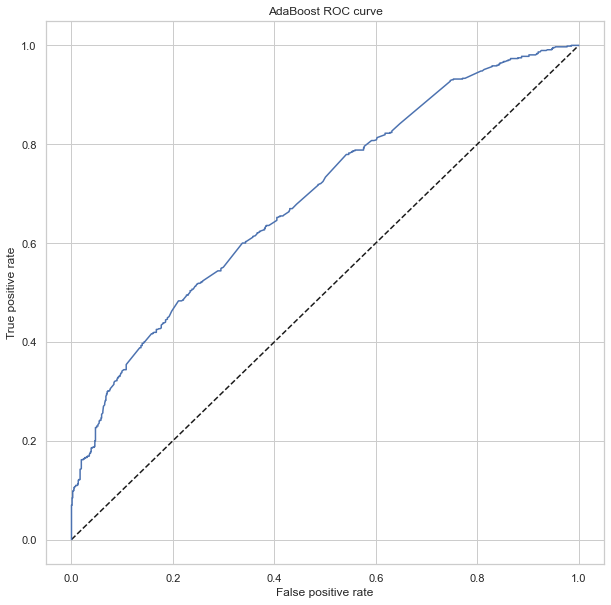

In [72]:
adaboost_model = AdaBoostClassifier(n_estimators=3, learning_rate=1, random_state=42)
params = {
    'n_estimators': [24,25,26],
    'learning_rate' : [0.9,1,1.1]
}
        
gsearch = GridSearchCV(estimator = adaboost_model, 
param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
gsearch.fit(X_train, y_train)
adaboost_model = gsearch
# print(gsearch.best_params_)
# print(gsearch.best_score_)
# print(gsearch.score(X_test, y_test))
# print(confusion_matrix(y_test, gsearch.predict(X_test)))
print('Best parameters are: ', gsearch.best_params_, '\n')
print('Best score:', gsearch.best_score_, '\n')
print('Current score:', gsearch.score(X_test, y_test), '\n')
print('Confusion matrix:', confusion_matrix(y_test, gsearch.predict(X_test)), '\n')
print('Metrics for model evaluation:\n', evaluate_model(y_test, gsearch.predict(X_test)), '\n')
plotROC(adaboost_model, X_test, y_test, 'AdaBoost')

### 5.2.5 Gradient Boosting Classifier

In [73]:
X = data_c.drop('target', axis=1)
y = data_c['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Best parameters are:  {'max_depth': 1, 'n_estimators': 1000} 

Best score: 0.7259070263557196 

Current score: 0.7042666666666666 

Confusion matrix: [[663 162]
 [359 316]] 

Metrics for model evaluation:
               precision    recall  f1-score   support

           0       0.65      0.80      0.72       825
           1       0.66      0.47      0.55       675

    accuracy                           0.65      1500
   macro avg       0.65      0.64      0.63      1500
weighted avg       0.65      0.65      0.64      1500
 



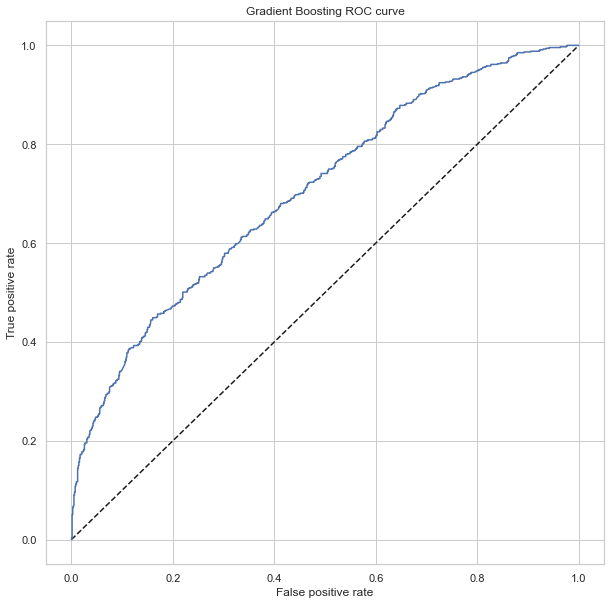

In [74]:
gboost_model = GradientBoostingClassifier(random_state=42)
params = {
    'n_estimators': [350, 500, 1000],
    'max_depth' : [1]
}
        
gsearch = GridSearchCV(estimator = gboost_model, 
param_grid = params, scoring='roc_auc', n_jobs=4, cv=5)
gsearch.fit(X_train, y_train)
gboost_model = gsearch
# print(gsearch.best_params_)
# print(gsearch.best_score_)
# print(gsearch.score(X_test, y_test))
# print(confusion_matrix(y_test, gsearch.predict(X_test)))
print('Best parameters are: ', gsearch.best_params_, '\n')
print('Best score:', gsearch.best_score_, '\n')
print('Current score:', gsearch.score(X_test, y_test), '\n')
print('Confusion matrix:', confusion_matrix(y_test, gsearch.predict(X_test)), '\n')
print('Metrics for model evaluation:\n', evaluate_model(y_test, gsearch.predict(X_test)), '\n')
plotROC(gboost_model, X_test, y_test, 'Gradient Boosting')

According to ensembles, we can make a conclusion while we used bootstraping for this data and calculating the scores our performance has improved as well. So we decided to use that ensembles for further predictions, because these algorithms are more efficient for usage to this dataset.

## 5.3 XGBoost

In [75]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV 

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [76]:
target = 'target'
predictors = [x for x in data_c.columns if x not in ['target']]

### 5.3.1 Function to estimate best parameters for XGBoost

In [77]:
def modelfit(alg, dtrain, predictors ,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    print(cvresult)
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy (test): %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions))
    print ("AUC Score (test): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### 5.3.2 Fix learning rate and number of estimators for tuning tree-based parameters

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.677946       0.004381       0.646460      0.012827
1        0.702421       0.010546       0.671720      0.017486
2        0.711185       0.010035       0.681795      0.017616
3        0.719003       0.010857       0.683105      0.013493
4        0.724514       0.011367       0.685841      0.014346
5        0.727757       0.011803       0.686979      0.014034
6        0.734514       0.010333       0.689371      0.013051
7        0.738190       0.007759       0.693251      0.017099
8        0.740791       0.008782       0.694584      0.016097
9        0.742996       0.009236       0.696680      0.015801

Model Report
Accuracy (test): 0.682
AUC Score (test): 0.731320


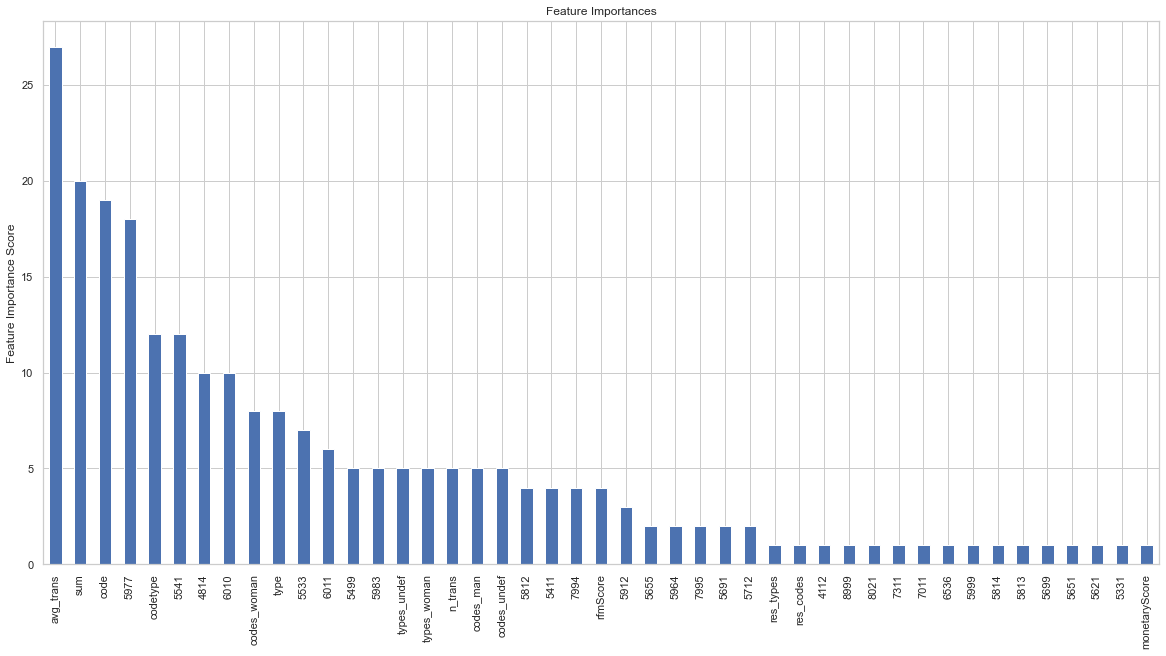

In [78]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=10,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder=False)


svresults = modelfit(xgb1, data_c, predictors)

### 5.3.3 Tune max_depth and min_child_weight

In [79]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=115, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(data_c[predictors],data_c[target])
gsearch1.best_params_, gsearch1.best_score_

[17:21:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 5, 'min_child_weight': 5}, 0.723242143532484)

In [80]:
param_test1 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=115, max_depth=3,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(data_c[predictors],data_c[target])
gsearch1.best_params_, gsearch1.best_score_

[17:34:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 4, 'min_child_weight': 6}, 0.7236248367925804)

### 5.3.4 Tune gamma

In [81]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators = 115, max_depth = 4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(data_c[predictors],data_c[target])
gsearch3.best_params_, gsearch3.best_score_

[17:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'gamma': 0.4}, 0.7242213880509657)

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.658419       0.006601       0.645905      0.012955
1          0.679882       0.010985       0.663188      0.019786
2          0.691012       0.006871       0.675100      0.015844
3          0.696644       0.008540       0.678899      0.013526
4          0.700587       0.007752       0.680180      0.014598
..              ...            ...            ...           ...
110        0.812709       0.003198       0.726552      0.008770
111        0.813371       0.002953       0.726953      0.008671
112        0.814084       0.002616       0.727301      0.008406
113        0.814592       0.002572       0.727659      0.008169
114        0.815455       0.002113       0.727675      0.008210

[115 rows x 4 columns]

Model Report
Accuracy (test): 0.7235
AUC Score (test): 0.806724


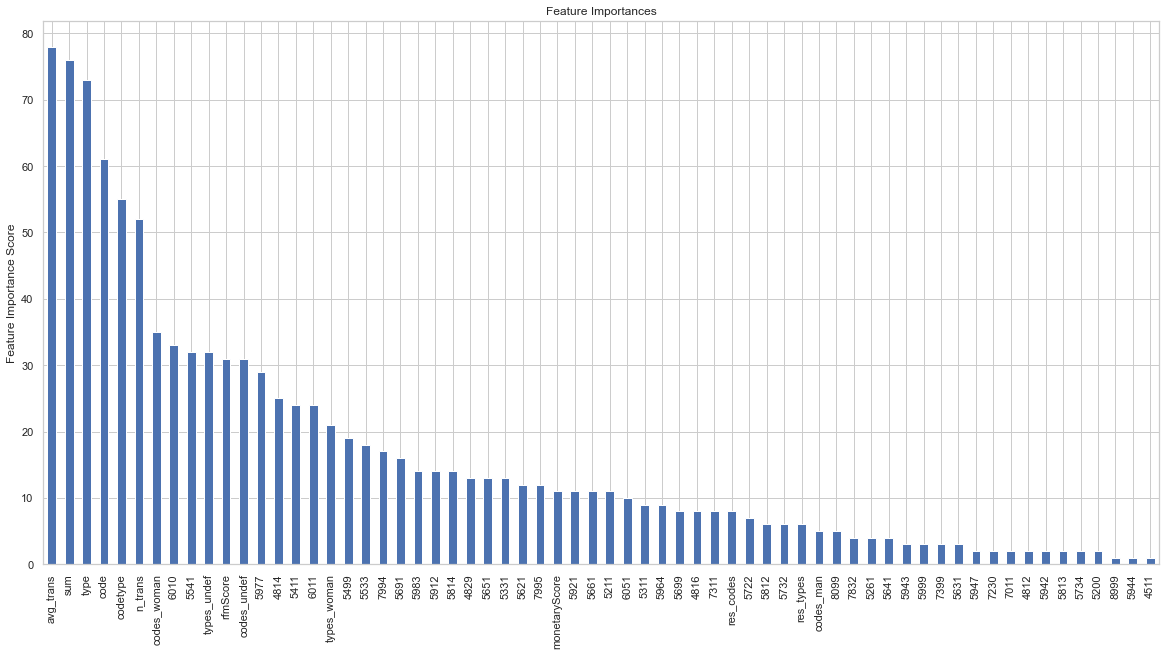

In [82]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=115,
 max_depth=4,
 min_child_weight=6,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder=False)


modelfit(xgb2, data_c, predictors)

### 5.3.5 Tune subsample and colsample_bytree

In [83]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators=115, max_depth=4,
 min_child_weight=6, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(data_c[predictors],data_c[target])
gsearch4.best_params_, gsearch4.best_score_

[17:38:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'colsample_bytree': 0.8, 'subsample': 0.7}, 0.7289859191391653)

### 5.3.6 Tuning Regularization Parameters

In [86]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=115, max_depth=4,
 min_child_weight=6, gamma=0.4, subsample=0.7, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(data_c[predictors],data_c[target])
gsearch6.best_params_, gsearch6.best_score_

[17:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 1e-05}, 0.7289856377470624)

### 5.3.7 Reducing Learning Rate

      train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0           0.658738       0.003892       0.645630      0.013370
1           0.679603       0.005637       0.660850      0.019331
2           0.685760       0.006912       0.668936      0.017555
3           0.688290       0.005464       0.668662      0.012035
4           0.691566       0.006833       0.668541      0.015455
...              ...            ...            ...           ...
1079        0.814591       0.001481       0.728653      0.008674
1080        0.814653       0.001508       0.728683      0.008664
1081        0.814681       0.001503       0.728674      0.008637
1082        0.814747       0.001484       0.728700      0.008665
1083        0.814769       0.001507       0.728708      0.008684

[1084 rows x 4 columns]

Model Report
Accuracy (test): 0.7207
AUC Score (test): 0.803883


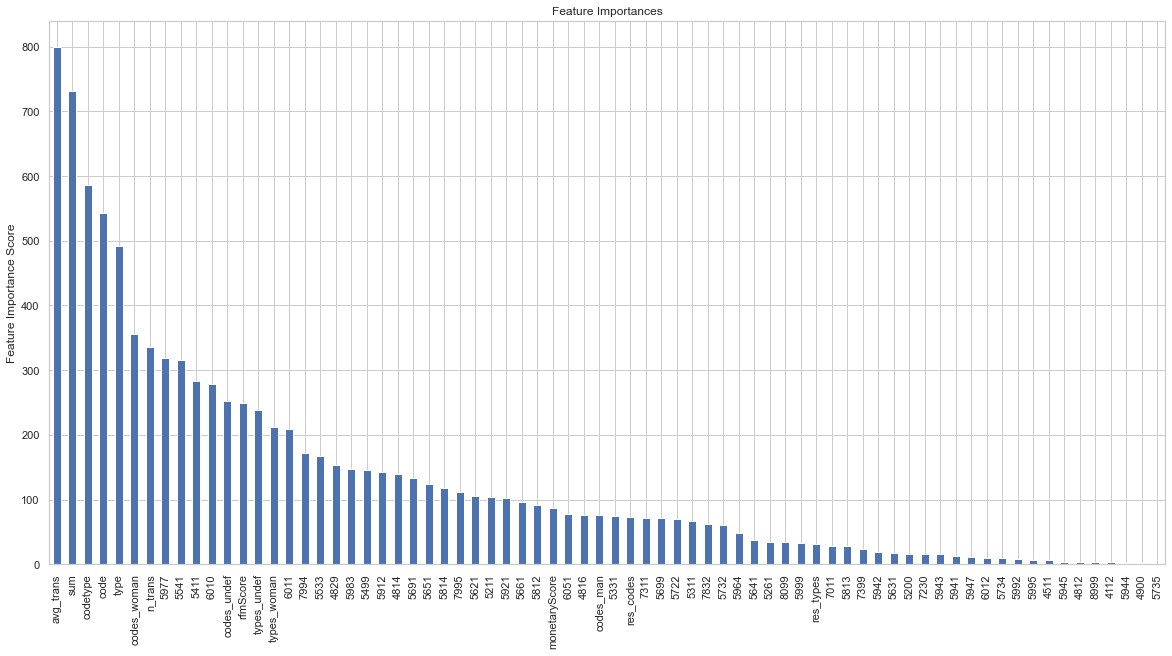

In [87]:
xgb_final = XGBClassifier(
 learning_rate =0.01,
 n_estimators=2000,
 max_depth=4,
 min_child_weight=6,
 gamma=0.4,
 subsample=0.7,
 colsample_bytree=0.8,
 reg_alpha=1e-5,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb_final, data_c, predictors)

### 5.3.8 XGBoost metrics

[17:42:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current score: 0.6613333333333333 

Confusion matrix: [[678 147]
 [361 314]] 

Metrics for model evaluation:               precision    recall  f1-score   support

           0       0.65      0.82      0.73       825
           1       0.68      0.47      0.55       675

    accuracy                           0.66      1500
   macro avg       0.67      0.64      0.64      1500
weighted avg       0.67      0.66      0.65      1500
 



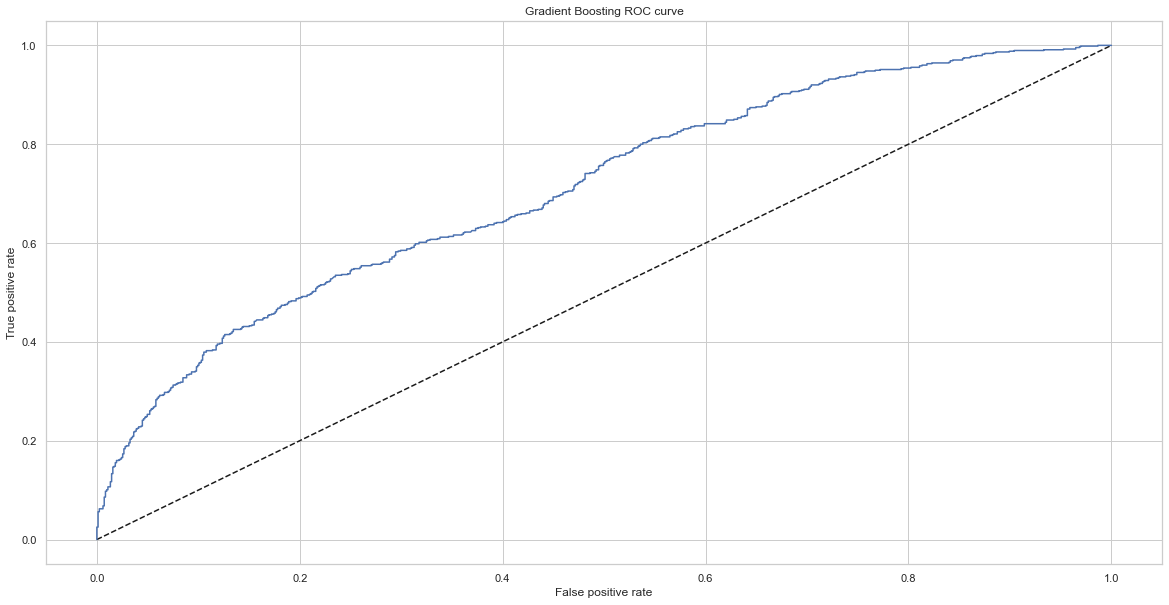

In [89]:
gsearch = xgb_final
gsearch.fit(X_train, y_train)
# print(gsearch.best_params_)
# print(gsearch.best_score_)
# print(gsearch.score(X_test, y_test))
# print(confusion_matrix(y_test, gsearch.predict(X_test)))
print('Current score:', gsearch.score(X_test, y_test), '\n')
print('Confusion matrix:', confusion_matrix(y_test, gsearch.predict(X_test)), '\n')
print('Metrics for model evaluation:', evaluate_model(y_test, gsearch.predict(X_test)), '\n')
plotROC(gsearch, X_test, y_test, 'Gradient Boosting')

# Final Conclusion

**The best and most precise results were obtained by data_c dataset, which is the merged from classifications and experiments. In addition, ensembles provided the most decent values. Precision, f1_score, recall also have been calculated to identify how does our model works.**